In [3]:
import os
import sys
import json
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Tuple, Dict, Any, Optional



In [2]:
# # import
# pickle_circuit = "../program_bank/2024_10_07__15_57__lintq/program_51.py_qc.pkl"

# import pickle
# qc = pickle.load(open(pickle_circuit, "rb"))

# qc.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘

In [4]:
DIR_PROGRAM_BANK = os.path.join("..", "program_bank", "2024_10_07__15_59__lintq")

In [18]:
from multiprocessing import Pool
import re

def read_json_file(file_path: str) -> Dict[str, Any]:
    with open(file_path, 'r') as file:
        data = json.load(file)
        data["_filename"] = os.path.basename(file_path)
        return data

def read_all_jsons(dir_path: str) -> pd.DataFrame:
    json_files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if re.match(r'.*\.json$', f)]
    records = []

    with Pool() as pool:
        results = pool.map(read_json_file, json_files)
        records.extend(results)

    return pd.DataFrame(records)

df = read_all_jsons(DIR_PROGRAM_BANK)


In [19]:
df.head()

,file,error_message,stack_trace,_filename
0,basic_optimize_6fc732.py,"Command '['docker', 'run', '--rm', '-v', '/tmp...","CalledProcessError(1, ['docker', 'run', '--rm'...",basic_optimize_6fc732.py.json
1,common_fcbe86.py,"Command '['docker', 'run', '--rm', '-v', '/tmp...","CalledProcessError(1, ['docker', 'run', '--rm'...",common_fcbe86.py.json
2,adjacent_crosstalk_detection_403bc0.py,"Command '['docker', 'run', '--rm', '-v', '/tmp...","CalledProcessError(1, ['docker', 'run', '--rm'...",adjacent_crosstalk_detection_403bc0.py.json
3,app_015156.py,"Command '['docker', 'run', '--rm', '-v', '/tmp...","CalledProcessError(1, ['docker', 'run', '--rm'...",app_015156.py.json
4,assignment_helper_34902f.py,"Command '['docker', 'run', '--rm', '-v', '/tmp...","CalledProcessError(1, ['docker', 'run', '--rm'...",assignment_helper_34902f.py.json


In [42]:
# clean stack trace

# anonymize filename
df["stack_trace"] = df.apply(
    lambda row: row["stack_trace"].replace(str(row["file"]), "this_file.py"), axis=1)

# anonymize the docker image name
df["stack_trace"] = df["stack_trace"].str.replace("qiskit_runner", "docker_image")


In [70]:
# print some stacktraces
top_k = 20
print("Top {} stacktraces".format(top_k))
print(df["stack_trace"].value_counts().head(top_k))


# check if the stack_trace contains "qiskit"
df["contains_qiskit"] = df.apply(
    lambda row: "qiskit" in row["stack_trace"].lower(), axis=1)
n_stack_traces_with_qiskit = df["contains_qiskit"].sum()
perc_stack_traces_with_qiskit = n_stack_traces_with_qiskit / len(df) * 100
print("Stack traces containing 'qiskit': {} ({:.2f}%)".format(n_stack_traces_with_qiskit, perc_stack_traces_with_qiskit))


def classify_error(message: str) -> Dict[str, Any]:
    if "ModuleNotFoundError" in message:
        return {
            "error_type": "ModuleNotFoundError",
            "detail": message.split("ModuleNotFoundError: ")[1]
            }
    elif "NameError" in message:
        if "get_ipython" in message:
            return {
                "error_type": "NameError",
                "detail": "get_ipython"
            }
        else:
            return {
                "error_type": "NameError",
                "detail": message.split("NameError: ")[1]
            }
    elif "SyntaxError" in message:
        return {
            "error_type": "SyntaxError",
            "detail": message.split("SyntaxError: ")[1]
        }
    elif "ImportError" in message:
        return {
            "error_type": "ImportError",
            "detail": message.split("ImportError: ")[1]
        }
    elif "TypeError" in message:
        return {
            "error_type": "TypeError",
            "detail": message.split("TypeError: ")[1]
        }
    elif "MissingOptionalLibraryError" in message:
        return {
            "error_type": "MissingOptionalLibraryError",
            "detail": message.split("MissingOptionalLibraryError: ")[1]
        }
    elif "FileNotFoundError" in message:
        return {
            "error_type": "FileNotFoundError",
            "detail": message.split("FileNotFoundError: ")[1]
        }
    elif "has no attribute" in message:
        return {
            "error_type": "AttributeError",
            "detail": message.split("<module>")[1]
        }
    elif "IndexError" in message:
        return {
            "error_type": "IndexError",
            "detail": message.split("IndexError: ")[1]
        }
    elif "No quantum computing framework available" in message:
        return {
            "error_type": "No QC framework",
            "detail": message
        }
    else:
        return {
            "error_type": "Other",
            "detail": message
        }

# unpack error classification and error detail
df[["error_classification", "error_detail"]] = df["stack_trace"].apply(
    lambda message: pd.Series(classify_error(message)))


Top 20 stacktraces
stack_trace
CalledProcessError(1, ['docker', 'run', '--rm', '-v', '/tmp/tmp42b_ghy2:/workspace', 'docker_image', 'python', '/workspace/this_file.py'], '', 'Traceback (most recent call last):\n  File "/workspace/this_file.py", line 4, in <module>\n    from qiskit import Aer\nImportError: cannot import name \'Aer\' from \'qiskit\' (/usr/local/lib/python3.10/site-packages/qiskit/__init__.py)\n')                                                                                      37
CalledProcessError(1, ['docker', 'run', '--rm', '-v', '/tmp/tmp42b_ghy2:/workspace', 'docker_image', 'python', '/workspace/this_file.py'], '', 'Traceback (most recent call last):\n  File "/workspace/this_file.py", line 3, in <module>\n    import matplotlib.pyplot as plt\nModuleNotFoundError: No module named \'matplotlib\'\n')                                                                                                                                              31
CalledProcessError(1, ['d

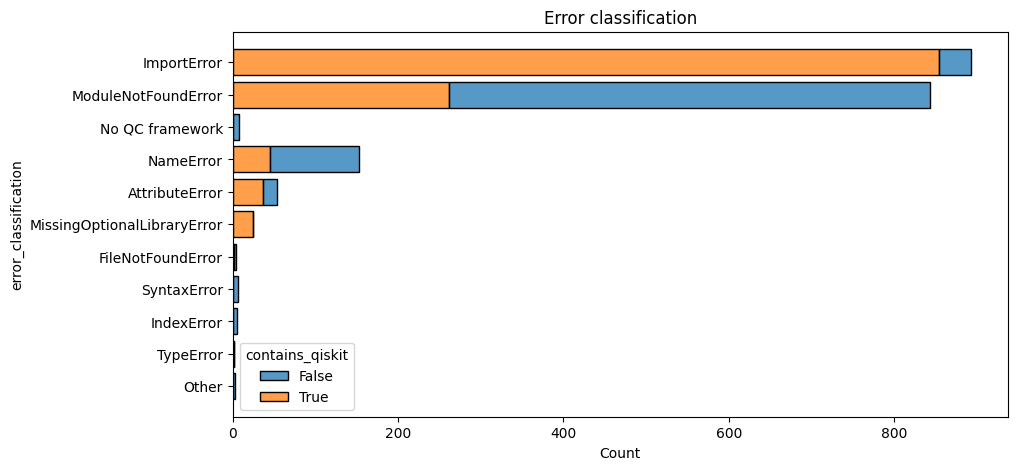

In [71]:
# plot the error classification stacked on top of each other cumulatively

plt.figure(figsize=(10, 5))
sns.histplot(data=df, y="error_classification", hue="contains_qiskit", multiple="stack", shrink=0.8)
plt.title("Error classification")
plt.show()

In [72]:
# pint those with errror_classification other
print("Top 10 error messages classified as 'Other'")
print(df[df["error_classification"] == "Other"]["error_detail"].value_counts().head(20))

Top 10 error messages classified as 'Other'
error_detail
CalledProcessError(1, ['docker', 'run', '--rm', '-v', '/tmp/tmp42b_ghy2:/workspace', 'docker_image', 'python', '/workspace/this_file.py'], 'Type your secret natural number : ', 'Traceback (most recent call last):\n  File "/workspace/this_file.py", line 6, in <module>\n    number = int(input("Type your secret natural number : "))\nEOFError: EOF when reading a line\n')                                                                                                   1
CalledProcessError(1, ['docker', 'run', '--rm', '-v', '/tmp/tmp42b_ghy2:/workspace', 'docker_image', 'python', '/workspace/this_file.py'], '', 'Traceback (most recent call last):\n  File "/workspace/this_file.py", line 57, in <module>\n    assert os.environ["IBMQE_API"] != "PUT_YOUR_API_TOKEN_HERE", "QX_API_TOKEN not updated!"\nAssertionError: QX_API_TOKEN not updated!\n')                                                                                             1
Cal